In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import time
import torch
import torch.optim as optim
from tqdm import tqdm_notebook
from matic_pytorch import GP_adapter

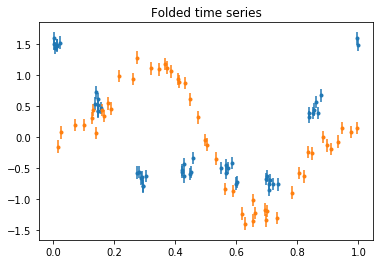

In [2]:
# Mock data to test
N = 50
s_noise = 0.1
per = np.array([1.4284, 0.8465])
t = np.linspace(0.0, 10.0, num=N)

lc_database = list()

t_uneven = t + 0.1*(10/N)*np.random.randn(N)
t_uneven = np.sort(t_uneven)
v_clean = np.cos(2.0*np.pi*t_uneven/per[0]) + 0.5*np.cos(4.0*np.pi*t_uneven/per[0]) 
v = v_clean + s_noise*np.random.randn(N)
e = s_noise*np.ones_like(v)
plt.errorbar(np.mod(t_uneven, per[0])/per[0], v, e, fmt='.')   
lc_database.append({'data': torch.from_numpy(np.stack((t_uneven, v, e)).astype('float32').T), 
                    'period': per[0], 'label': 0})

t_uneven = t + 0.1*(10/N)*np.random.randn(N)
t_uneven = np.sort(t_uneven)
v_clean = np.sin(2.0*np.pi*t_uneven/per[1]) - 0.5*np.sin(4.0*np.pi*t_uneven/per[1]) 
v = v_clean + s_noise*np.random.randn(N)
e = s_noise*np.ones_like(v)
lc_database.append({'data': torch.from_numpy(np.stack((t_uneven, v, e)).astype('float32').T), 
                    'period': per[1], 'label': 1})
plt.errorbar(np.mod(t_uneven, per[1])/per[1], v, e, fmt='.')  
 
plt.title("Folded time series");

In [17]:
# Parameters
n_mc_samples = 64
n_pivots = 100
n_neuron_conv = 32
n_classes = 2  
n_epoch = 100

net = GP_adapter(n_pivots, n_mc_samples, n_neuron_conv, n_classes)
print(net)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = torch.nn.NLLLoss()


for k in tqdm_notebook(range(n_epoch), desc='Epochs'): 
    for sample in lc_database: # data samples
        targets = torch.tensor(sample['label']).repeat(n_mc_samples)
        output = net(sample)
        optimizer.zero_grad()
        loss = criterion(output, targets)
        #print(k, loss.item())
        loss.backward()
        optimizer.step()

GP_adapter(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (gpool): AvgPool1d(kernel_size=(94,), stride=(1,), padding=(0,))
  (fc1): Linear(in_features=32, out_features=2, bias=True)
)


Widget Javascript not detected.  It may not be installed or enabled properly.


In [18]:
 for i, sample in enumerate(lc_database):
    pred_proba = torch.exp(net.forward(sample)).detach().numpy()
    pred_label = np.argmax(np.mean(pred_proba, axis=0))
    print("%d: Predicted class %d, Average pbb:%f, std_dev:%f" %(i, pred_label, 
                                                                 np.mean(pred_proba, axis=0)[i], np.std(pred_proba, axis=0)[i]))

0: Predicted class 0, Average pbb:0.515607, std_dev:0.033110
1: Predicted class 1, Average pbb:0.566611, std_dev:0.030365


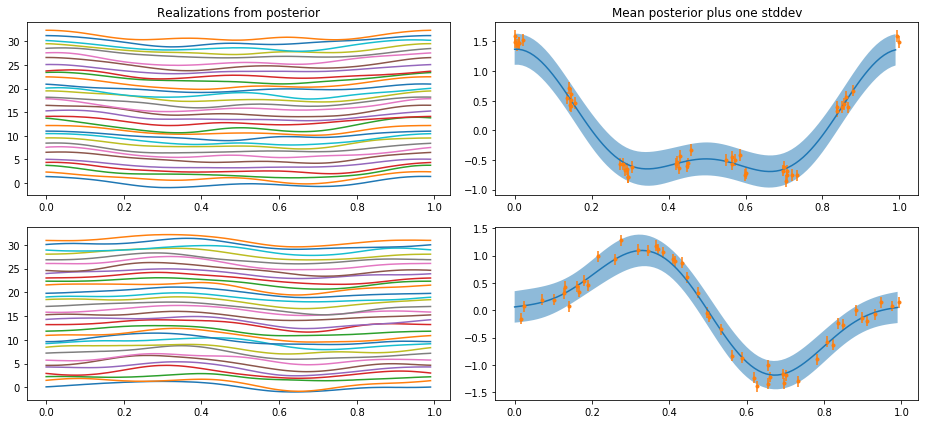

In [19]:
fig = plt.figure(figsize=(13, 6))

for i, sample in enumerate(lc_database):
    ax = fig.add_subplot(2, 2, 2*i+1)
    if i == 0:
        ax.set_title('Realizations from posterior')
    output, (mu, R, x) = net.forward(sample, return_gp=True)
    z = net.sample_from_posterior(mu, R).detach().numpy()
    x = x[0, :].detach().numpy()
    mu = mu[0, :].detach().numpy()
    s = torch.sqrt(torch.sum(R**2, dim=0)).detach().numpy()
    for k in range(32):
        ax.plot(x, k+ z[k, :] )
    ax = fig.add_subplot(2, 2, 2*i+2)
    if i == 0:
        ax.set_title('Mean posterior plus one stddev')    
    ax.plot(x, mu)
    ax.fill_between(x, mu  - s, mu +s, alpha=0.5)
    lc = sample['data'].detach().numpy()
    ax.errorbar(np.mod(lc[:, 0], sample['period'])/sample['period'], lc[:, 1], lc[:, 2], fmt='.')

plt.tight_layout();